## Projection simulations check:
- check dVdt -> corresponds approximately to Hugonnet et al. by comparing W5E5 vs W5E5_spinup
    - e.g.: https://nbviewer.org/urls/cluster.klima.uni-bremen.de/~pschmitt/dynamic_prepro/analysis_dyn_spn.ipynb?flush_cache=true
    - and: https://nbviewer.org/urls/cluster.klima.uni-bremen.de/~lschuster/error_analysis/working_glacier_gdirs_comparison.ipynb


In [63]:
from oggm import cfg, workflow, utils, shop
import pandas as pd
import os, glob
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
cfg.initialize()
import seaborn as sns
sns.set_context('talk')

2023-05-31 18:08:45: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-05-31 18:08:45: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-05-31 18:08:45: oggm.cfg: Multiprocessing: using all available processors (N=32)


In [64]:
pd_geodetic = utils.get_geodetic_mb_dataframe()[utils.get_geodetic_mb_dataframe().period=='2000-01-01_2020-01-01']

In [65]:
working_all = True
if working_all:
    pd_working_all = pd.read_csv('/home/www/lschuster/runs_oggm_v16/analysis_notebooks/common_working_rgi_ids_prepro_2023.3_vs_2023.2_w10.csv', #
                                index_col = 'Unnamed: 0')
else:
    all_running_rgis_d = {}
    for hist in ['w5e5_gcm_merged', 'gcm_from_2000']:
        #for bc in ['_bc_2000_2019']:
        pd_working = pd.read_csv(f'working_rgis_for_oggm_v16_CMIP6{bc}_{hist}.csv', index_col='rgiid', low_memory=False)
        all_running_rgis_d[hist] = pd_working['all_running_rgis'].dropna().index.values
        print(len(all_running_rgis_d[hist]))
    all_running_rgis = list(set(all_running_rgis_d['w5e5_gcm_merged']).intersection(all_running_rgis_d['gcm_from_2000']))
    pd_working_all = pd_working.loc[all_running_rgis][['area','all_running_rgis', 'rgi_reg']]
    pd_working_all = pd_working_all.dropna()

In [66]:
all_running_rgis = pd_working_all.index.values
pd_geodetic_running = pd_geodetic.loc[all_running_rgis]

In [67]:
period = '2000-01-01_2020-01-01'

#dfz = pd.read_csv(utils.get_demo_file('zemp_ref_2006_2016.csv'), index_col=0)
#dfh['dmdt_zemp'] = dfz.SMB.values * 1000
#dfh['dmdt_zemp_err'] = dfz.SMB_err.values * 1000
dfh = pd.read_csv(utils.get_demo_file('table_hugonnet_regions_10yr_20yr_ar6period.csv'), index_col=0)
dfh = dfh.loc[dfh.period == period]
dfh.index = ['{:02d}'.format(int(rgi_reg)) for rgi_reg in dfh.index]

In [68]:
# get those geodetic estimates of the common running glaciers and then do the area-weighted mean! 
dmdtda_working_glaciers_geods = {}
dmdt_working_glaciers_geods = {}
for reg in np.arange(1,20,1):
    pd_geodetic_running_reg = pd_geodetic_running[pd_geodetic_running.reg == reg]
    dmdtda_working_glaciers_geod = np.average(pd_geodetic_running_reg.dmdtda*1e3, weights=pd_geodetic_running_reg.area)
    #
    #dmdt_working_glaciers_geod = (pd_geodetic_running_reg.dmdtda*1e3*pd_geodetic_running_reg.area).sum()*1e-12
    # I don't have the dmdt per glacier, so need to convert from dmdtda to dmdt by multiplying by the area 
    dmdt_working_glaciers_geod = (pd_geodetic_running_reg.dmdtda*1e3*pd_geodetic_running_reg.area).sum()*1e-12
    rgi_reg  = '{:02d}'.format(reg)
    dmdtda_working_glaciers_geods[rgi_reg] = dmdtda_working_glaciers_geod
    dmdt_working_glaciers_geods[rgi_reg] = dmdt_working_glaciers_geod
pd_working_glaciers_geod =pd.DataFrame([dmdt_working_glaciers_geods,dmdtda_working_glaciers_geods],
                                       index=['dmdt_geodetic_only_running_glaciers',
                                              'dmdtda_geodetic_only_running_glaciers']).astype(float)





In [69]:
version = '2023.3'

In [70]:
# ok the summary statistcs are all the same except for glacier_statistics....
run = False
border = '160'
if run:
    path = f'/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/{version}/elev_bands'
    for rgi_reg in np.arange(1, 20):
        rgi_reg_int = rgi_reg.copy()

        rgi_reg = '{:02d}'.format(rgi_reg)
        all_running_rgis_reg = pd_working_all.loc[pd_working_all.rgi_reg==rgi_reg_int]['all_running_rgis'].dropna().index

        ds_l = []
        df_l = []
        dfs_l = []
        for opt in ['W5E5', 'W5E5_spinup']:

            fd = f'{path}/{opt}/RGI62/b_{border}/L5/summary/'


            df_l.append(pd.read_csv(fd + f'fixed_geometry_mass_balance_{rgi_reg}.csv'.format(rgi_reg), index_col=0, low_memory=False))
            dfs_l.append(pd.read_csv(fd + f'glacier_statistics_{rgi_reg}.csv'.format(rgi_reg), index_col=0, low_memory=False))
            with xr.open_dataset(fd + f'historical_run_output_extended_{rgi_reg}.nc') as ds:
                ds = ds[['volume', 'area']].sum(dim='rgi_id')
                ds_l.append(ds)
        np.testing.assert_allclose(df_l[0], df_l[1])
        np.testing.assert_allclose(ds_l[0].volume, ds_l[1].volume)
        np.testing.assert_allclose(ds_l[0].area, ds_l[1].area)

In [81]:
run = False
if run:
    aletschi_l = []
    for version in ['2023.3']: #['2023.2', '2023.3']:
        dfh = pd.read_csv(utils.get_demo_file('table_hugonnet_regions_10yr_20yr_ar6period.csv'),
                          index_col=0)
        dfh = dfh.loc[dfh.period == period]
        dfh.index = ['{:02d}'.format(int(rgi_reg)) for rgi_reg in dfh.index]
        
        for border in ['080','160']:
            if (version == '2023.2') and (border == '080'):
                continue
            else:
                for opt in ['W5E5', 'W5E5_spinup', 'W5E5_spinup_10']:
                    if (opt == 'W5E5_spinup_10') and ((version == '2023.2') or (border == '080')): 
                        continue
                    else:
                        path = f'/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/{version}/elev_bands'
                        fd = f'{path}/{opt}/RGI62/b_{border}/L5/summary/'
                        b = f'_b_{border}' 
                        print(b)
                        for rgi_reg in np.arange(1, 20):
                            rgi_reg_int = rgi_reg
                            all_running_rgis_reg = pd_geodetic_running.loc[pd_geodetic_running.reg ==rgi_reg_int].index.values
                            rgi_reg = '{:02d}'.format(rgi_reg)


                            try:
                                df = pd.read_csv(fd + f'fixed_geometry_mass_balance_{rgi_reg}.csv'.format(rgi_reg), index_col=0,
                                                 low_memory=False)
                                dfs = pd.read_csv(fd + f'glacier_statistics_{rgi_reg}.csv'.format(rgi_reg), index_col=0,
                                                  low_memory=False)
                            except FileNotFoundError:
                                print('Not here:',rgi_reg)
                                continue

                            df = df.dropna(axis=0, how='all')
                            # just choose those glaciers that work for all prepro gdirs types!
                            df = df[all_running_rgis_reg]
                            # check if there are no np.NaNs (otherwise sth. is wrong with all_running_rgis_reg)
                            assert ~np.any(df.isna())
                            #df = df.dropna(axis=1, how='all')
                            #         odf = pd.DataFrame(df.loc[2006:2016].mean(), columns=['SMB'])
                            #         odf['AREA'] = dfs.rgi_area_km2

                            #         dfh.loc[rgi_reg, 'AREA_OGGM'] = odf['AREA'].sum()
                            #         dfh.loc[rgi_reg, 'SMB_OGGM'] = np.average(odf['SMB'], weights=odf['AREA']) / 1000

                            odf = pd.DataFrame(df.loc[2000:].mean(), columns=['SMB'])
                            odf['AREA'] = dfs.rgi_area_km2

                            if opt == 'W5E5':
                                stat = f'historical_run_output_extended_{rgi_reg}.nc'
                            else:
                                stat = f'spinup_historical_run_output_{rgi_reg}.nc'
                            with xr.open_dataset(fd +stat) as ds:
                                ds = ds.sel(rgi_id=all_running_rgis_reg)      
                                ##ry:
                                 #   ds_a = ds.isel(rgi_id=0).volume
                                 #   aletschi_l.append((ds_a.sel(time=2020)- ds_a.sel(time=2000)).values/20)
                                #e#xcept:
                                 #   pass
                                ds = ds[['volume', 'area']].sum(dim='rgi_id')
                            vol_ts = ds.volume.to_series()
                            area_ts = ds.area.to_series()


                            # dmdt is in kg per year *10e-12 # 2020 or 2019 ??????-> I think 2020 is more correct actually!!!
                            dfh.loc[rgi_reg, f'dmdt_OGGM_{opt}{b}'] = (vol_ts.loc[2020] - vol_ts.loc[2000]) * cfg.PARAMS['ice_density'] * 1e-12 / 20
                            dfh.loc[rgi_reg, f'dmdtda_OGGM_{opt}{b}'] = np.average(odf['SMB'], weights=odf['AREA'])

                            # dmdt is in kg per year *10e-12 # 2020 or 2019 ??????-> I think 2020 is more correct actually!!!
                            dfh.loc[rgi_reg, f'dmdt_dyna_OGGM_{opt}{b}'] = (vol_ts.loc[2020] - vol_ts.loc[2000]) * cfg.PARAMS['ice_density'] * 1e-12 / 20
                            dfh.loc[rgi_reg, f'dmdtda_dyna_OGGM_{opt}{b}'] = (vol_ts.loc[2019] - vol_ts.loc[2000]) / area_ts.loc[2000] * cfg.PARAMS['ice_density'] / 20 
                            dfh.loc[rgi_reg, f'area_OGGM_2000_{opt}{b}'] = area_ts.loc[2000]       
                            dfh.loc[rgi_reg, f'vol_OGGM_2000_{opt}{b}'] = vol_ts.loc[2000]  

                            #with xr.open_mfdataset(f'/home/www/lschuster/runs_oggm_v16/output_with_negative_melt/RGI{rgi_reg}/run_hydro_w5e5_gcm_merged_endyr2100_CMIP6_BCC-CSM2-MR_ssp245_bc_2000_2019_rgi{rgi_reg}*.nc') as dproj:
                            #    dproj = dproj.sel(rgi_id=all_running_rgis_reg)
                            #    dproj = dproj[['volume', 'area']].sum(dim='rgi_id')
                            #vol_ts = dproj.volume.to_series()
                            #area_ts = dproj.area.to_series()
                            #dproj.close()

                            #dfh.loc[rgi_reg, f'dmdtda_dyna_OGGM_proj_{opt}'] = (vol_ts.loc[2019] - vol_ts.loc[2000]) / area_ts.loc[2000] * cfg.PARAMS['ice_density'] / 20 
                            #dfh.loc[rgi_reg, f'area_OGGM_2000_proj_{opt}'] = area_ts.loc[2000]       
                            #dfh.loc[rgi_reg, f'vol_OGGM_2000_proj_{opt}'] = vol_ts.loc[2000]  

            dfhh = pd.concat([dfh, pd_working_glaciers_geod.T], axis=1)
            dfhh.to_csv(f'oggm_v161_w5e5_spinup_dmdtda_area_vol_for_prepro_level_5_gdirs_{version}.csv')
else:
    dfh_d = {}
    for version in ['2023.2', '2023.3']:
        # new with (partly) preprocessed gdirs
        dfh = pd.read_csv(f'oggm_v161_w5e5_spinup_dmdtda_area_vol_for_prepro_level_5_gdirs_{version}.csv', index_col=[0])
        # old with wrong preprocessed gdirs: dfh = pd.read_csv(f'dmdtda_dmdt_for_prepro_level_5_gdirs.csv', index_col=[0])
        dfh.index = ['{:02d}'.format(int(rgi_reg)) for rgi_reg in dfh.index]
        dfh_d[version] = dfh

In [74]:
pd_geodetic_running.groupby('reg').sum()

area        dmdtda    err_dmdtda  is_cor
reg                                                  
1    8.671082e+10 -11507.342166   7006.215046     325
2    1.451379e+10  -6358.386435   5162.869007    1354
3    1.050701e+11  -1702.163201    675.834755      34
4    4.087932e+10  -3138.716537   1488.980083      36
5    8.970929e+10  -5451.318830   3916.627983     177
6    1.105953e+10   -191.906557    105.864661       1
7    3.418701e+10   -482.488926    238.909255       3
8    2.947809e+09  -1385.283149    865.896168      43
9    5.157186e+10   -312.933900    144.193200       0
10   2.319683e+09  -2020.580200   1739.960806     172
11   2.089463e+09  -2275.340174   1514.675467     499
12   1.327656e+09   -709.136051    454.971892     308
13   4.922673e+10 -11207.549150  13851.803920     945
14   3.355836e+10  -3095.707394   7172.393175    1046
15   1.472241e+10  -5688.035557   3601.314850     350
16   2.336622e+09   -945.937649    813.145087     203
17   2.938551e+10  -3503.219730   4958.174501    1385
18   1.161016e+09   -697.571660   1225.944188     518
19   1.326115e+11   -394.780058    666.731560     255

In [82]:
# Ok, I can't really check if it corresponds to pd_geodetic_running.area, because I would need to check it for the RGI year, which is different for the glaicers...
dfh[['area_OGGM_2000_W5E5_b_160', 'area_OGGM_2000_W5E5_spinup_b_160', 'area_OGGM_2000_W5E5_spinup_10_b_160', 'area_OGGM_2000_W5E5_b_080', 'area_OGGM_2000_W5E5_spinup_b_080']] #, 'area_OGGM_2000_proj_W5E5_spinup'

area_OGGM_2000_W5E5_b_160  area_OGGM_2000_W5E5_spinup_b_160  \
01               8.671094e+10                      8.796067e+10   
02               1.500305e+10                      1.555199e+10   
03               1.050702e+11                      1.054581e+11   
04               4.090303e+10                      4.137431e+10   
05               8.971565e+10                      9.094299e+10   
06               1.105953e+10                      1.108364e+10   
07               3.397113e+10                      3.413797e+10   
08               2.947801e+09                      3.129873e+09   
09               5.157183e+10                      5.177218e+10   
10               2.319670e+09                      2.617046e+09   
11               2.089526e+09                      2.140509e+09   
12               1.150210e+09                      1.166256e+09   
13               4.922569e+10                      5.071868e+10   
14               3.360171e+10                      3.457512e+10   
15               1.472199e+10                      1.492367e+10   
16               2.336706e+09                      2.452967e+09   
17               2.938550e+10                      2.976108e+10   
18               1.172062e+09                      1.175464e+09   
19               1.358082e+11                      1.358982e+11   

    area_OGGM_2000_W5E5_spinup_10_b_160  area_OGGM_2000_W5E5_b_080  \
01                         8.795661e+10               8.671094e+10   
02                         1.556745e+10               1.493765e+10   
03                         1.054647e+11               1.050702e+11   
04                         4.138378e+10               4.089714e+10   
05                         9.096003e+10               8.971432e+10   
06                         1.108342e+10               1.105953e+10   
07                         3.413649e+10               3.397089e+10   
08                         3.133746e+09               2.947800e+09   
09                         5.177265e+10               5.157183e+10   
10                         2.617118e+09               2.319670e+09   
11                         2.141084e+09               2.089523e+09   
12                         1.165627e+09               1.150209e+09   
13                         5.074002e+10               4.922552e+10   
14                         3.460019e+10               3.359835e+10   
15                         1.492472e+10               1.472196e+10   
16                         2.453536e+09               2.336735e+09   
17                         2.975984e+10               2.938549e+10   
18                         1.175936e+09               1.171530e+09   
19                         1.359464e+11               1.357799e+11   

    area_OGGM_2000_W5E5_spinup_b_080  
01                      8.788815e+10  
02                      1.546659e+10  
03                      1.054018e+11  
04                      4.131124e+10  
05                      9.080566e+10  
06                      1.108324e+10  
07                      3.413237e+10  
08                      3.115678e+09  
09                      5.177491e+10  
10                      2.580936e+09  
11                      2.137966e+09  
12                      1.165245e+09  
13                      5.058323e+10  
14                      3.444770e+10  
15                      1.488379e+10  
16                      2.437405e+09  
17                      2.972732e+10  
18                      1.179270e+09  
19                      1.358672e+11

In [76]:
dfh[['vol_OGGM_2000_W5E5_b_160', 'vol_OGGM_2000_W5E5_spinup_b_160', 'vol_OGGM_2000_W5E5_spinup_10_b_160', 'vol_OGGM_2000_W5E5_b_080', 'vol_OGGM_2000_W5E5_spinup_b_080']]#, 'vol_OGGM_2000_proj_W5E5_spinup']]

vol_OGGM_2000_W5E5_b_160  vol_OGGM_2000_W5E5_spinup_b_160  \
01              1.946098e+13                     1.968114e+13   
02              1.078968e+12                     1.024080e+12   
03              2.832074e+13                     2.751424e+13   
04              8.671868e+12                     8.737624e+12   
05              1.577024e+13                     1.554247e+13   
06              3.785237e+12                     3.794713e+12   
07              7.565840e+12                     7.556657e+12   
08              3.061045e+11                     3.086965e+11   
09              1.468843e+13                     1.400277e+13   
10              1.406923e+11                     1.341359e+11   
11              1.328446e+11                     1.277287e+11   
12              6.015605e+10                     6.148033e+10   
13              3.311210e+12                     3.312507e+12   
14              2.893478e+12                     2.883120e+12   
15              9.024602e+11                     8.887690e+11   
16              9.743851e+10                     9.293899e+10   
17              5.338705e+12                     5.146233e+12   
18              6.889402e+10                     6.797843e+10   
19              4.596006e+13                     4.544639e+13   

    vol_OGGM_2000_W5E5_spinup_10_b_160  vol_OGGM_2000_W5E5_b_080  \
01                        1.968420e+13              1.946100e+13   
02                        1.025658e+12              1.078809e+12   
03                        2.751833e+13              2.832080e+13   
04                        8.742087e+12              8.671854e+12   
05                        1.555090e+13              1.577025e+13   
06                        3.793482e+12              3.785235e+12   
07                        7.557518e+12              7.565858e+12   
08                        3.094127e+11              3.060973e+11   
09                        1.400670e+13              1.468843e+13   
10                        1.341249e+11              1.406863e+11   
11                        1.276478e+11              1.328443e+11   
12                        6.137734e+10              6.015658e+10   
13                        3.315042e+12              3.311203e+12   
14                        2.886032e+12              2.893487e+12   
15                        8.895708e+11              9.024439e+11   
16                        9.287288e+10              9.744248e+10   
17                        5.147728e+12              5.338721e+12   
18                        6.790066e+10              6.887492e+10   
19                        4.545303e+13              4.596050e+13   

    vol_OGGM_2000_W5E5_spinup_b_080  
01                     1.968128e+13  
02                     1.024711e+12  
03                     2.750705e+13  
04                     8.743315e+12  
05                     1.554102e+13  
06                     3.793507e+12  
07                     7.551359e+12  
08                     3.086720e+11  
09                     1.400218e+13  
10                     1.338853e+11  
11                     1.277750e+11  
12                     6.149819e+10  
13                     3.310335e+12  
14                     2.883483e+12  
15                     8.883124e+11  
16                     9.275247e+10  
17                     5.146542e+12  
18                     6.815937e+10  
19                     4.536253e+13

In [80]:
dfh.columns

Index(['period', 'dmdt', 'err_dmdt', 'dmdtda', 'err_dmdtda',
       'dmdt_OGGM_W5E5_b_080', 'dmdtda_OGGM_W5E5_b_080',
       'dmdt_dyna_OGGM_W5E5_b_080', 'dmdtda_dyna_OGGM_W5E5_b_080',
       'area_OGGM_2000_W5E5_b_080', 'vol_OGGM_2000_W5E5_b_080',
       'dmdt_OGGM_W5E5_spinup_b_080', 'dmdtda_OGGM_W5E5_spinup_b_080',
       'dmdt_dyna_OGGM_W5E5_spinup_b_080',
       'dmdtda_dyna_OGGM_W5E5_spinup_b_080',
       'area_OGGM_2000_W5E5_spinup_b_080', 'vol_OGGM_2000_W5E5_spinup_b_080',
       'dmdt_OGGM_W5E5_b_160', 'dmdtda_OGGM_W5E5_b_160',
       'dmdt_dyna_OGGM_W5E5_b_160', 'dmdtda_dyna_OGGM_W5E5_b_160',
       'area_OGGM_2000_W5E5_b_160', 'vol_OGGM_2000_W5E5_b_160',
       'dmdt_OGGM_W5E5_spinup_b_160', 'dmdtda_OGGM_W5E5_spinup_b_160',
       'dmdt_dyna_OGGM_W5E5_spinup_b_160',
       'dmdtda_dyna_OGGM_W5E5_spinup_b_160',
       'area_OGGM_2000_W5E5_spinup_b_160', 'vol_OGGM_2000_W5E5_spinup_b_160',
       'dmdt_geodetic_only_running_glaciers',
       'dmdtda_geodetic_only_running_glacie

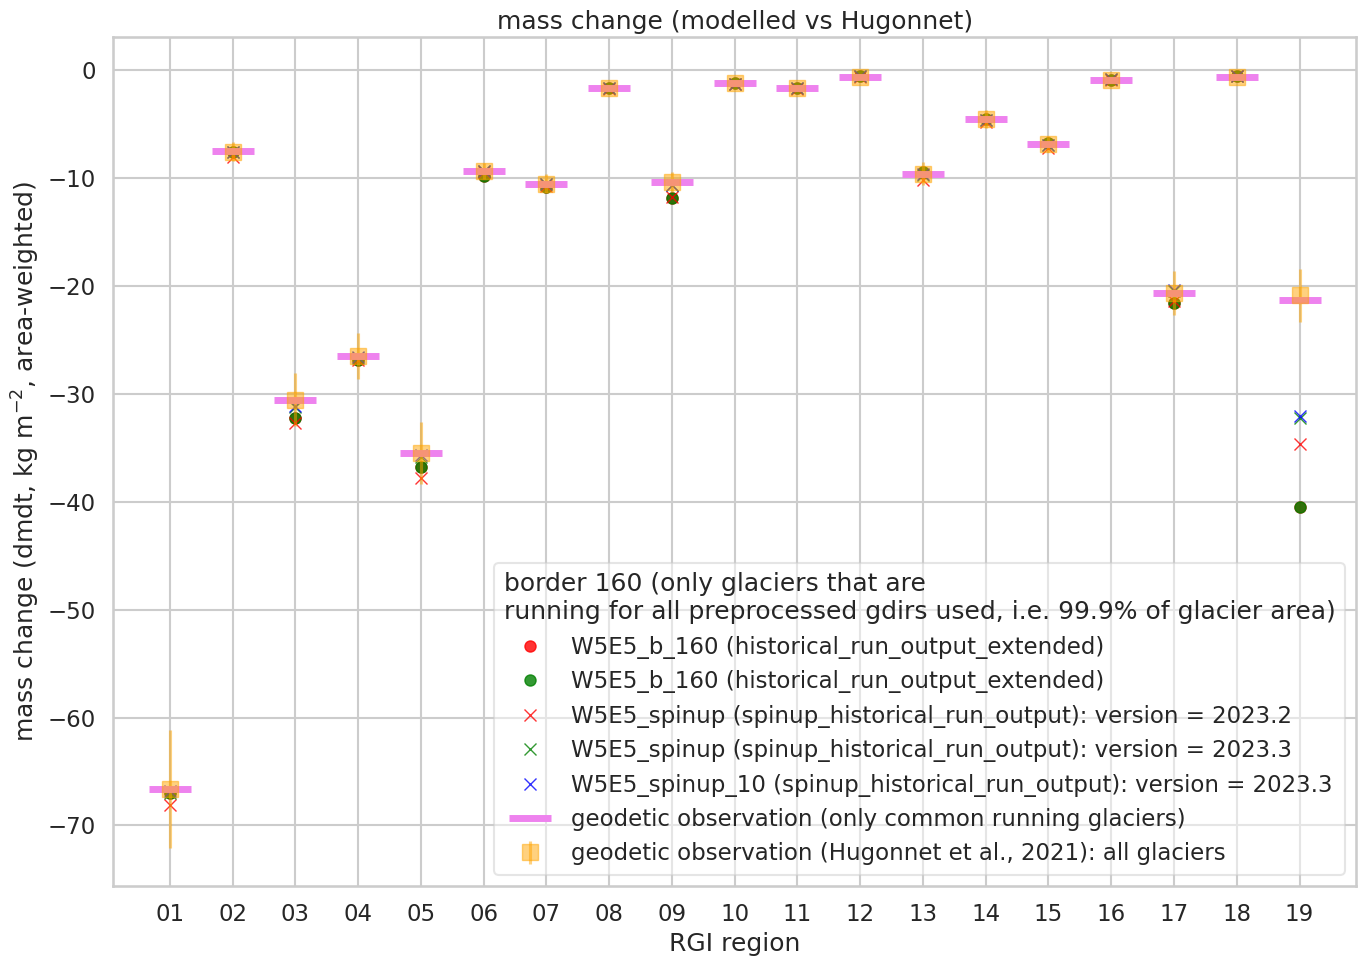

In [83]:
plt.figure(figsize=(14,10))
ax = plt.gca()

#f, ax = plt.subplots()
#alphas = {'elev_bands': 1, 'centerlines':0.5}
color_d = {'2023.2':'red', '2023.3':'green'}
markers = {'W5E5': 'o', 'W5E5_spinup': 'x',  'W5E5_spinup_10': 'x'}
b = '_b_160'
for opt in ['W5E5', 'W5E5_spinup', 'W5E5_spinup_10']:
        if opt=='W5E5_spinup':
            #dfh.plot(ax=ax, y=f'dmdtda_dyna_OGGM_proj_{opt}', marker='s',
            #                 linestyle='none', markersize=4, color = 'black', alpha = 1, #alphas[exp],
            #                 label=f'W5E5 dynamical run using prepro {opt}')
            for j,version in enumerate(['2023.2', '2023.3']):
                dfh = dfh_d[version]
                dfh.plot(ax=ax, y=f'dmdt_dyna_OGGM_{opt}{b}', marker=markers[opt],
                                 linestyle='none', markersize=8, color = color_d[version],
                         alpha = 0.8, #alphas[exp],
                                 label=f'{opt} (spinup_historical_run_output): version = {version}')
        elif opt== 'W5E5_spinup_10':
            dfh = dfh_d['2023.3']
            dfh.plot(ax=ax, y=f'dmdt_dyna_OGGM_{opt}{b}', marker=markers[opt],
                                 linestyle='none', markersize=8, color = 'blue',
                         alpha = 0.8, #alphas[exp],
                                 label=f'{opt} (spinup_historical_run_output): version = {version}')
        else:
            for j,version in enumerate(['2023.2', '2023.3']):
                dfh = dfh_d[version]
                dfh.plot(ax=ax, y=f'dmdt_dyna_OGGM_{opt}{b}', marker=markers[opt],
                     linestyle='none', markersize=8, color = color_d[version],
                         alpha = 0.8, #alphas[exp],
                     label=f'{opt}{b} (historical_run_output_extended)')

dfh.plot(ax=ax, y='dmdt', yerr='err_dmdt', marker='s', linestyle='none', markersize=12,
         label = 'geodetic observation (Hugonnet et al., 2021): all glaciers', color = 'orange',
         alpha = 0.5)
dfh.plot(ax=ax, y='dmdt_geodetic_only_running_glaciers', marker="_", linestyle='none', markersize=30,
                   label = 'geodetic observation (only common running glaciers)', color = 'violet', alpha = 1, markeredgewidth=5)
plt.ylabel(r'mass change (dmdt, kg m$^{-2}$, area-weighted)')
plt.xlabel('RGI region')
plt.title('mass change (modelled vs Hugonnet)') # from "spinup/historical_run_output_extended"
plt.xticks(np.arange(0,19,1), dfh.index.values);
#plt.ylim([-1400,-50])
ax.legend(framealpha=0.5, ncol=1, loc='lower right', 
          title=f'border {border} (only glaciers that are\nrunning for all preprocessed gdirs used, i.e. {100*pd_geodetic_running.area.sum()/pd_geodetic.area.sum():0.1f}% of glacier area)')

plt.tight_layout()

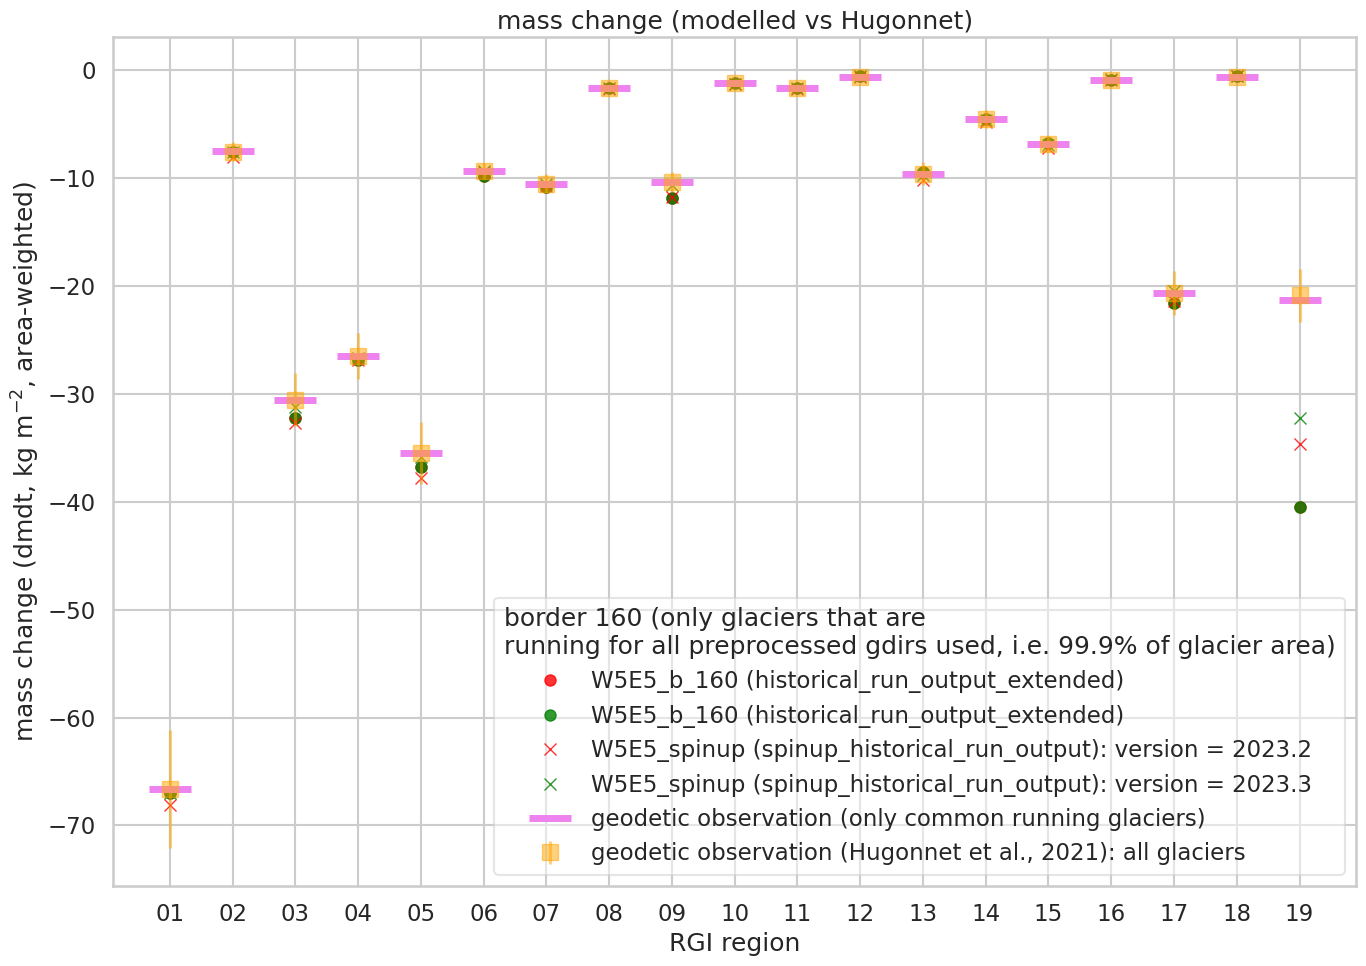

In [51]:
plt.figure(figsize=(14,10))
ax = plt.gca()

#f, ax = plt.subplots()
#alphas = {'elev_bands': 1, 'centerlines':0.5}
color_d = {'2023.2':'red', '2023.3':'green'}
markers = {'W5E5': 'o', 'W5E5_spinup': 'x'}
b = '_b_160'
for opt in ['W5E5', 'W5E5_spinup', 'W5E5_spinup_10']:
        if opt=='W5E5_spinup':
            #dfh.plot(ax=ax, y=f'dmdtda_dyna_OGGM_proj_{opt}', marker='s',
            #                 linestyle='none', markersize=4, color = 'black', alpha = 1, #alphas[exp],
            #                 label=f'W5E5 dynamical run using prepro {opt}')
            for j,version in enumerate(['2023.2', '2023.3']):
                dfh = dfh_d[version]
                dfh.plot(ax=ax, y=f'dmdt_dyna_OGGM_{opt}{b}', marker=markers[opt],
                                 linestyle='none', markersize=8, color = color_d[version],
                         alpha = 0.8, #alphas[exp],
                                 label=f'{opt} (spinup_historical_run_output): version = {version}')
        elif opt== 'W5E5_spinup_10':
            dfh = dfh_d['2023.3']
            dfh.plot(ax=ax, y=f'dmdt_dyna_OGGM_{opt}{b}', marker=markers[opt],
                                 linestyle='none', markersize=8, color = 'blue',
                         alpha = 0.8, #alphas[exp],
                                 label=f'{opt} (spinup_historical_run_output): version = {version}')
        else:
            for j,version in enumerate(['2023.2', '2023.3']):
                dfh = dfh_d[version]
                dfh.plot(ax=ax, y=f'dmdt_dyna_OGGM_{opt}{b}', marker=markers[opt],
                     linestyle='none', markersize=8, color = color_d[version],
                         alpha = 0.8, #alphas[exp],
                     label=f'{opt}{b} (historical_run_output_extended)')

dfh.plot(ax=ax, y='dmdt', yerr='err_dmdt', marker='s', linestyle='none', markersize=12,
         label = 'geodetic observation (Hugonnet et al., 2021): all glaciers', color = 'orange',
         alpha = 0.5)
dfh.plot(ax=ax, y='dmdt_geodetic_only_running_glaciers', marker="_", linestyle='none', markersize=30,
                   label = 'geodetic observation (only common running glaciers)', color = 'violet', alpha = 1, markeredgewidth=5)
plt.ylabel(r'mass change (dmdt, kg m$^{-2}$, area-weighted)')
plt.xlabel('RGI region')
plt.title('mass change (modelled vs Hugonnet)') # from "spinup/historical_run_output_extended"
plt.xticks(np.arange(0,19,1), dfh.index.values);
#plt.ylim([-1400,-50])
ax.legend(framealpha=0.5, ncol=1, loc='lower right', 
          title=f'border {border} (only glaciers that are\nrunning for all preprocessed gdirs used, i.e. {100*pd_geodetic_running.area.sum()/pd_geodetic.area.sum():0.1f}% of glacier area)')

plt.tight_layout()

In [86]:
dfh['diff']

01    -0.188548
02    -0.032390
03    -0.621377
04    -0.051544
05    -0.149248
06    -0.018673
07    -0.015435
08    -0.011151
09    -0.192634
10    -0.056059
11     0.011514
12     0.089723
13    -0.008001
14    -0.041530
15    -0.059005
16     0.053048
17     0.285334
18     0.080362
19   -10.769028
Name: diff, dtype: float64

01     1.463800
02     0.466538
03     2.188610
04     0.384308
05     2.254468
06     0.085052
07     0.219561
08     0.051128
09     1.306599
10     0.135834
11     0.049950
12     0.057511
13     0.528721
14     0.273804
15     0.320057
16     0.044491
17     0.742539
18     0.064860
19    13.367847
Name: diff, dtype: float64
01     0.360399
02     0.094737
03     0.725186
04     0.159694
05     0.338983
06     0.020561
07     0.021522
08     0.024509
09     0.236375
10     0.064685
11     0.004496
12     0.080368
13     0.103470
14     0.111483
15     0.094533
16     0.050703
17     0.223497
18     0.079418
19    10.889447
Name: diff, dtype: float64
b_080 01     0.361437
02     0.091868
03     0.734245
04     0.161582
05     0.366067
06     0.102582
07     0.023102
08     0.020355
09     0.240008
10     0.057125
11     0.005347
12     0.081046
13     0.094316
14     0.100571
15     0.036618
16     0.059615
17     0.268135
18     0.078876
19    10.904735
Name: diff, dtype: float64


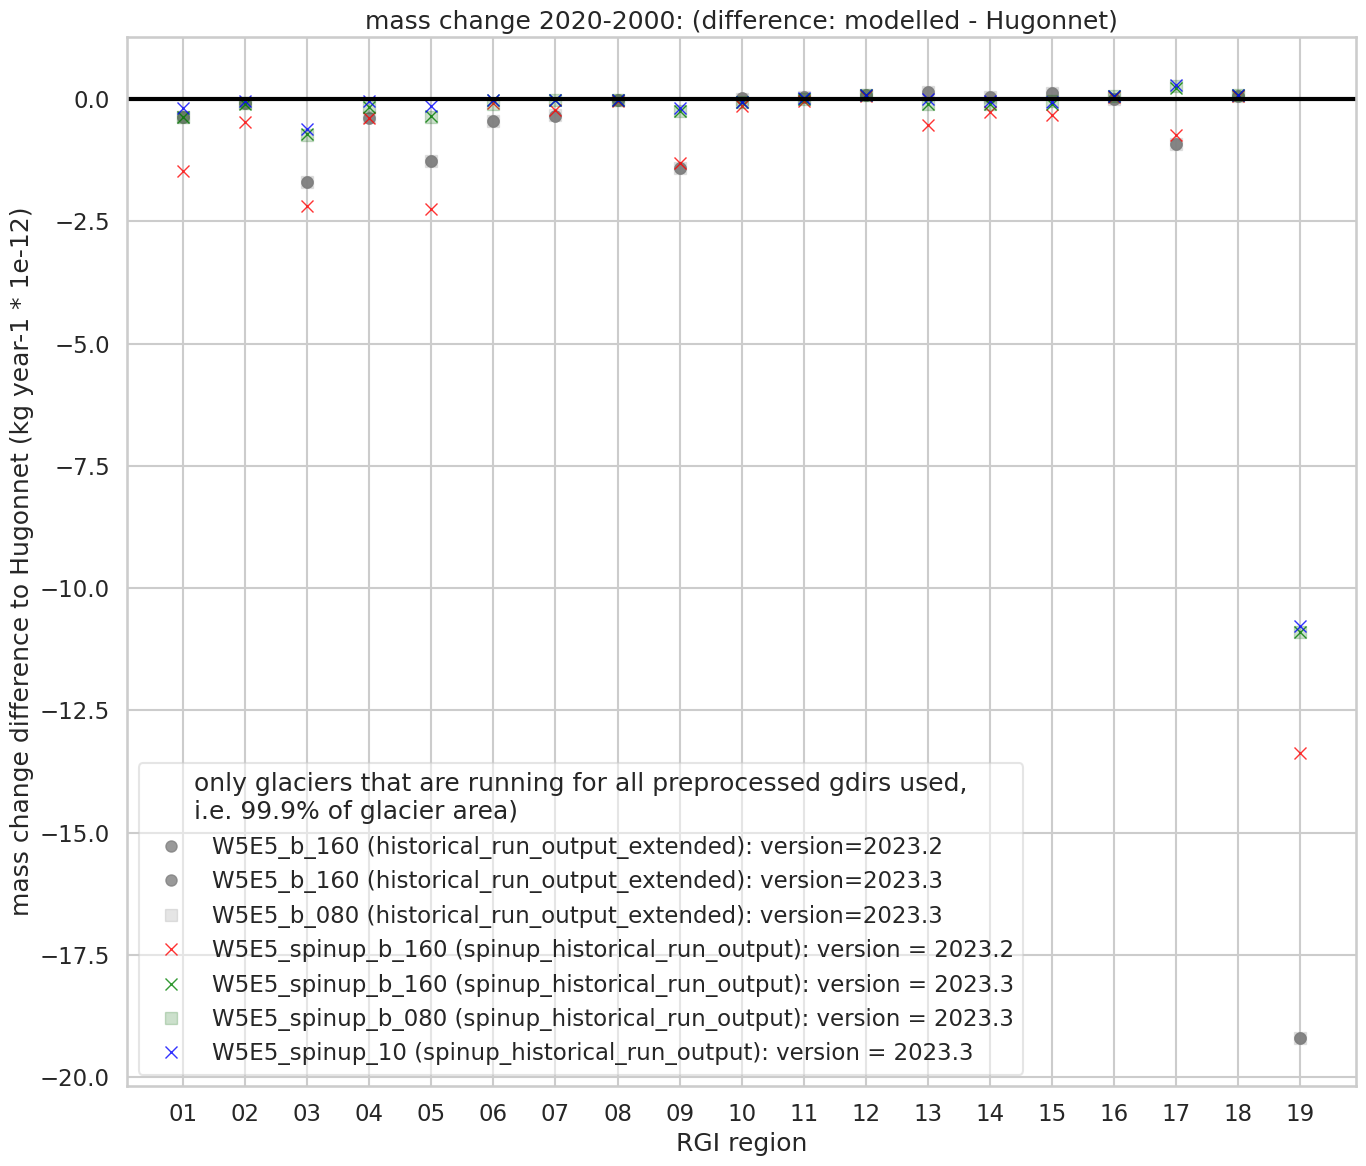

In [87]:
plt.figure(figsize=(14,12))
ax = plt.gca()

#f, ax = plt.subplots()
#alphas = {'elev_bands': 1, 'centerlines':0.5}
color_d = {'2023.2':'red', '2023.3':'green'}
markers = {'W5E5': 'o', 'W5E5_spinup': 'x','W5E5_spinup_10': 'x'}
for opt in ['W5E5', 'W5E5_spinup','W5E5_spinup_10']:
        if opt=='W5E5_spinup':
            #dfh.plot(ax=ax, y=f'dmdtda_dyna_OGGM_proj_{opt}', marker='s',
            #                 linestyle='none', markersize=4, color = 'black', alpha = 1, #alphas[exp],
            #                 label=f'W5E5 dynamical run using prepro {opt}')
            for j,version in enumerate(['2023.2', '2023.3']):
                dfh = dfh_d[version]
                dfh['diff'] = dfh[f'dmdt_dyna_OGGM_{opt}_b_160'] - dfh.dmdt_geodetic_only_running_glaciers
                print(np.abs(dfh['diff']))
                dfh.plot(ax=ax, y='diff', marker=markers[opt],
                                 linestyle='none', markersize=8, color = color_d[version],
                         alpha = 0.8, #alphas[exp],
                                 label=f'{opt}_b_160 (spinup_historical_run_output): version = {version}')
                if version == '2023.3':
                    dfh['diff'] = dfh[f'dmdt_dyna_OGGM_{opt}_b_080'] - dfh.dmdt_geodetic_only_running_glaciers
                    print('b_080', np.abs(dfh['diff']))
                    dfh.plot(ax=ax, y='diff', marker='s',
                                     linestyle='none', markersize=8, color = 'darkgreen',
                             alpha = 0.2, #alphas[exp],
                                     label=f'{opt}_b_080 (spinup_historical_run_output): version = {version}')
                    
        elif opt== 'W5E5_spinup_10':
            dfh = dfh_d['2023.3']
            dfh['diff'] = dfh[f'dmdt_dyna_OGGM_{opt}_b_160'] - dfh.dmdt_geodetic_only_running_glaciers
            dfh.plot(ax=ax, y='diff', marker=markers[opt],
                     linestyle='none', markersize=8, color = 'blue',
                     alpha = 0.8, #alphas[exp],
                     label=f'{opt} (spinup_historical_run_output): version = 2023.3')

        else:
            for j,version in enumerate(['2023.2', '2023.3']):
                dfh = dfh_d[version]
                dfh['diff'] = dfh[f'dmdt_dyna_OGGM_{opt}_b_160'] - dfh.dmdt_geodetic_only_running_glaciers
                dfh.plot(ax=ax, y='diff', marker=markers[opt],
                     linestyle='none', markersize=8, color = 'grey',
                         alpha = 0.8, #alphas[exp],
                     label=f'{opt}_b_160 (historical_run_output_extended): version={version}')
                if version == '2023.3':
                    dfh['diff'] = dfh[f'dmdt_dyna_OGGM_{opt}_b_080'] - dfh.dmdt_geodetic_only_running_glaciers
                    dfh.plot(ax=ax, y='diff', marker='s',
                         linestyle='none', markersize=8, color = 'grey',
                             alpha = 0.2, #alphas[exp],
                         label=f'{opt}_b_080 (historical_run_output_extended): version={version}')
                    
plt.ylabel(r'mass change difference to Hugonnet (kg year-1 * 1e-12)')
plt.xlabel('RGI region')
plt.title('mass change 2020-2000: (difference: modelled - Hugonnet)') # from "spinup/historical_run_output_extended"
plt.xticks(np.arange(0,19,1), dfh.index.values);
#plt.ylim([-1400,-50])
ax.legend(framealpha=0.5, ncol=1, #loc='upper left', 
          title=f'only glaciers that are running for all preprocessed gdirs used,\ni.e. {100*pd_geodetic_running.area.sum()/pd_geodetic.area.sum():0.1f}% of glacier area)')
plt.axhline(0, lw=3, color='black')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(14,12))
ax = plt.gca()

#f, ax = plt.subplots()
#alphas = {'elev_bands': 1, 'centerlines':0.5}
color_d = {'2023.2':'red', '2023.3':'green'}
markers = {'W5E5': 'o', 'W5E5_spinup': 'x', 'W5E5_spinup_10': 'x'}
for opt in ['W5E5', 'W5E5_spinup', 'W5E5_spinup_10']:
        if opt=='W5E5_spinup':
            #dfh.plot(ax=ax, y=f'dmdtda_dyna_OGGM_proj_{opt}', marker='s',
            #                 linestyle='none', markersize=4, color = 'black', alpha = 1, #alphas[exp],
            #                 label=f'W5E5 dynamical run using prepro {opt}')
            for j,version in enumerate(['2023.2', '2023.3']):
                dfh = dfh_d[version]
                dfh['ratio'] = dfh[f'dmdt_dyna_OGGM_{opt}_b_160'] / dfh.dmdt_geodetic_only_running_glaciers
                print(np.abs(dfh['ratio']))
                dfh.plot(ax=ax, y='ratio', marker=markers[opt],
                                 linestyle='none', markersize=8, color = color_d[version],
                         alpha = 0.8, #alphas[exp],
                                 label=f'{opt}_b_160 (spinup_historical_run_output): version = {version}')
                if version == '2023.3':
                    dfh['ratio'] = dfh[f'dmdt_dyna_OGGM_{opt}_b_080'] / dfh.dmdt_geodetic_only_running_glaciers
                    print('b_080', np.abs(dfh['ratio']))
                    dfh.plot(ax=ax, y='ratio', marker='s',
                                     linestyle='none', markersize=8, color = 'darkgreen',
                             alpha = 0.2, #alphas[exp],
                                     label=f'{opt}_b_080 (spinup_historical_run_output): version = {version}')
        elif opt== 'W5E5_spinup_10':
            dfh = dfh_d['2023.3']
            dfh['ratio'] = dfh[f'dmdt_dyna_OGGM_{opt}_b_160'] / dfh.dmdt_geodetic_only_running_glaciers
            dfh.plot(ax=ax, y='ratio', marker=markers[opt],
                     linestyle='none', markersize=8, color = 'blue',
                     alpha = 0.8, #alphas[exp],
                     label=f'{opt} (spinup_historical_run_output): version = 2023.3')
        else:
            for j,version in enumerate(['2023.2', '2023.3']):
                dfh = dfh_d[version]
                dfh['ratio'] = dfh[f'dmdt_dyna_OGGM_{opt}_b_160'] / dfh.dmdt_geodetic_only_running_glaciers
                dfh.plot(ax=ax, y='ratio', marker=markers[opt],
                     linestyle='none', markersize=8, color = 'grey',
                         alpha = 0.8, #alphas[exp],
                     label=f'{opt}_b_160 (historical_run_output_extended): version={version}')
                if version == '2023.3':
                    dfh['ratio'] = dfh[f'dmdt_dyna_OGGM_{opt}_b_080'] / dfh.dmdt_geodetic_only_running_glaciers
                    dfh.plot(ax=ax, y='ratio', marker='s',
                         linestyle='none', markersize=8, color = 'grey',
                             alpha = 0.2, #alphas[exp],
                         label=f'{opt}_b_080 (historical_run_output_extended): version={version}')
                    
plt.ylabel(r'mass change relative to Hugonnet ')
plt.xlabel('RGI region')
plt.title('mass change 2020-2000: (ratio: modelled /Hugonnet)') # from "spinup/historical_run_output_extended"
plt.xticks(np.arange(0,19,1), dfh.index.values);
#plt.ylim([-1400,-50])
ax.legend(framealpha=0.5, ncol=1, #loc='upper left', 
          title=f'only glaciers that are running for all preprocessed gdirs used,\ni.e. {100*pd_geodetic_running.area.sum()/pd_geodetic.area.sum():0.1f}% of glacier area)')
plt.axhline(1, lw=3, color='black')
plt.tight_layout()

01    1.021967
02    1.061788
03    1.071656
04    1.014501
05    1.063483
06    1.009086
07    1.020833
08    1.030687
09    1.125383
10    1.112483
11    1.029686
12    0.914518
13    1.054905
14    1.060031
15    1.046464
16    0.952316
17    1.035897
18    0.899282
19    1.626731
Name: ratio, dtype: float64
01    1.005409
02    1.012548
03    1.023743
04    1.006026
05    1.009545
06    1.002197
07    1.002042
08    1.014710
09    1.022683
10    1.053565
11    0.997327
12    0.880501
13    1.010745
14    1.024443
15    1.013725
16    0.945634
17    0.989195
18    0.876675
19    1.510535
Name: ratio, dtype: float64
b_080 01    1.005424
02    1.012168
03    1.024039
04    1.006097
05    1.010308
06    1.010959
07    1.002192
08    1.012217
09    1.023031
10    1.047305
11    0.996822
12    0.879492
13    1.009794
14    1.022051
15    1.005316
16    0.936079
17    0.987037
18    0.877516
19    1.511252
Name: ratio, dtype: float64


- in most cases b_80 and b_160 similar for the common running glaciers
    - for a few regions (RGI10, RGI15)-> border 80 gives more similar mass changes relative to Hugonnet compared to b_160,
    - in other regions (16, 06), it is the other way around

## OLD

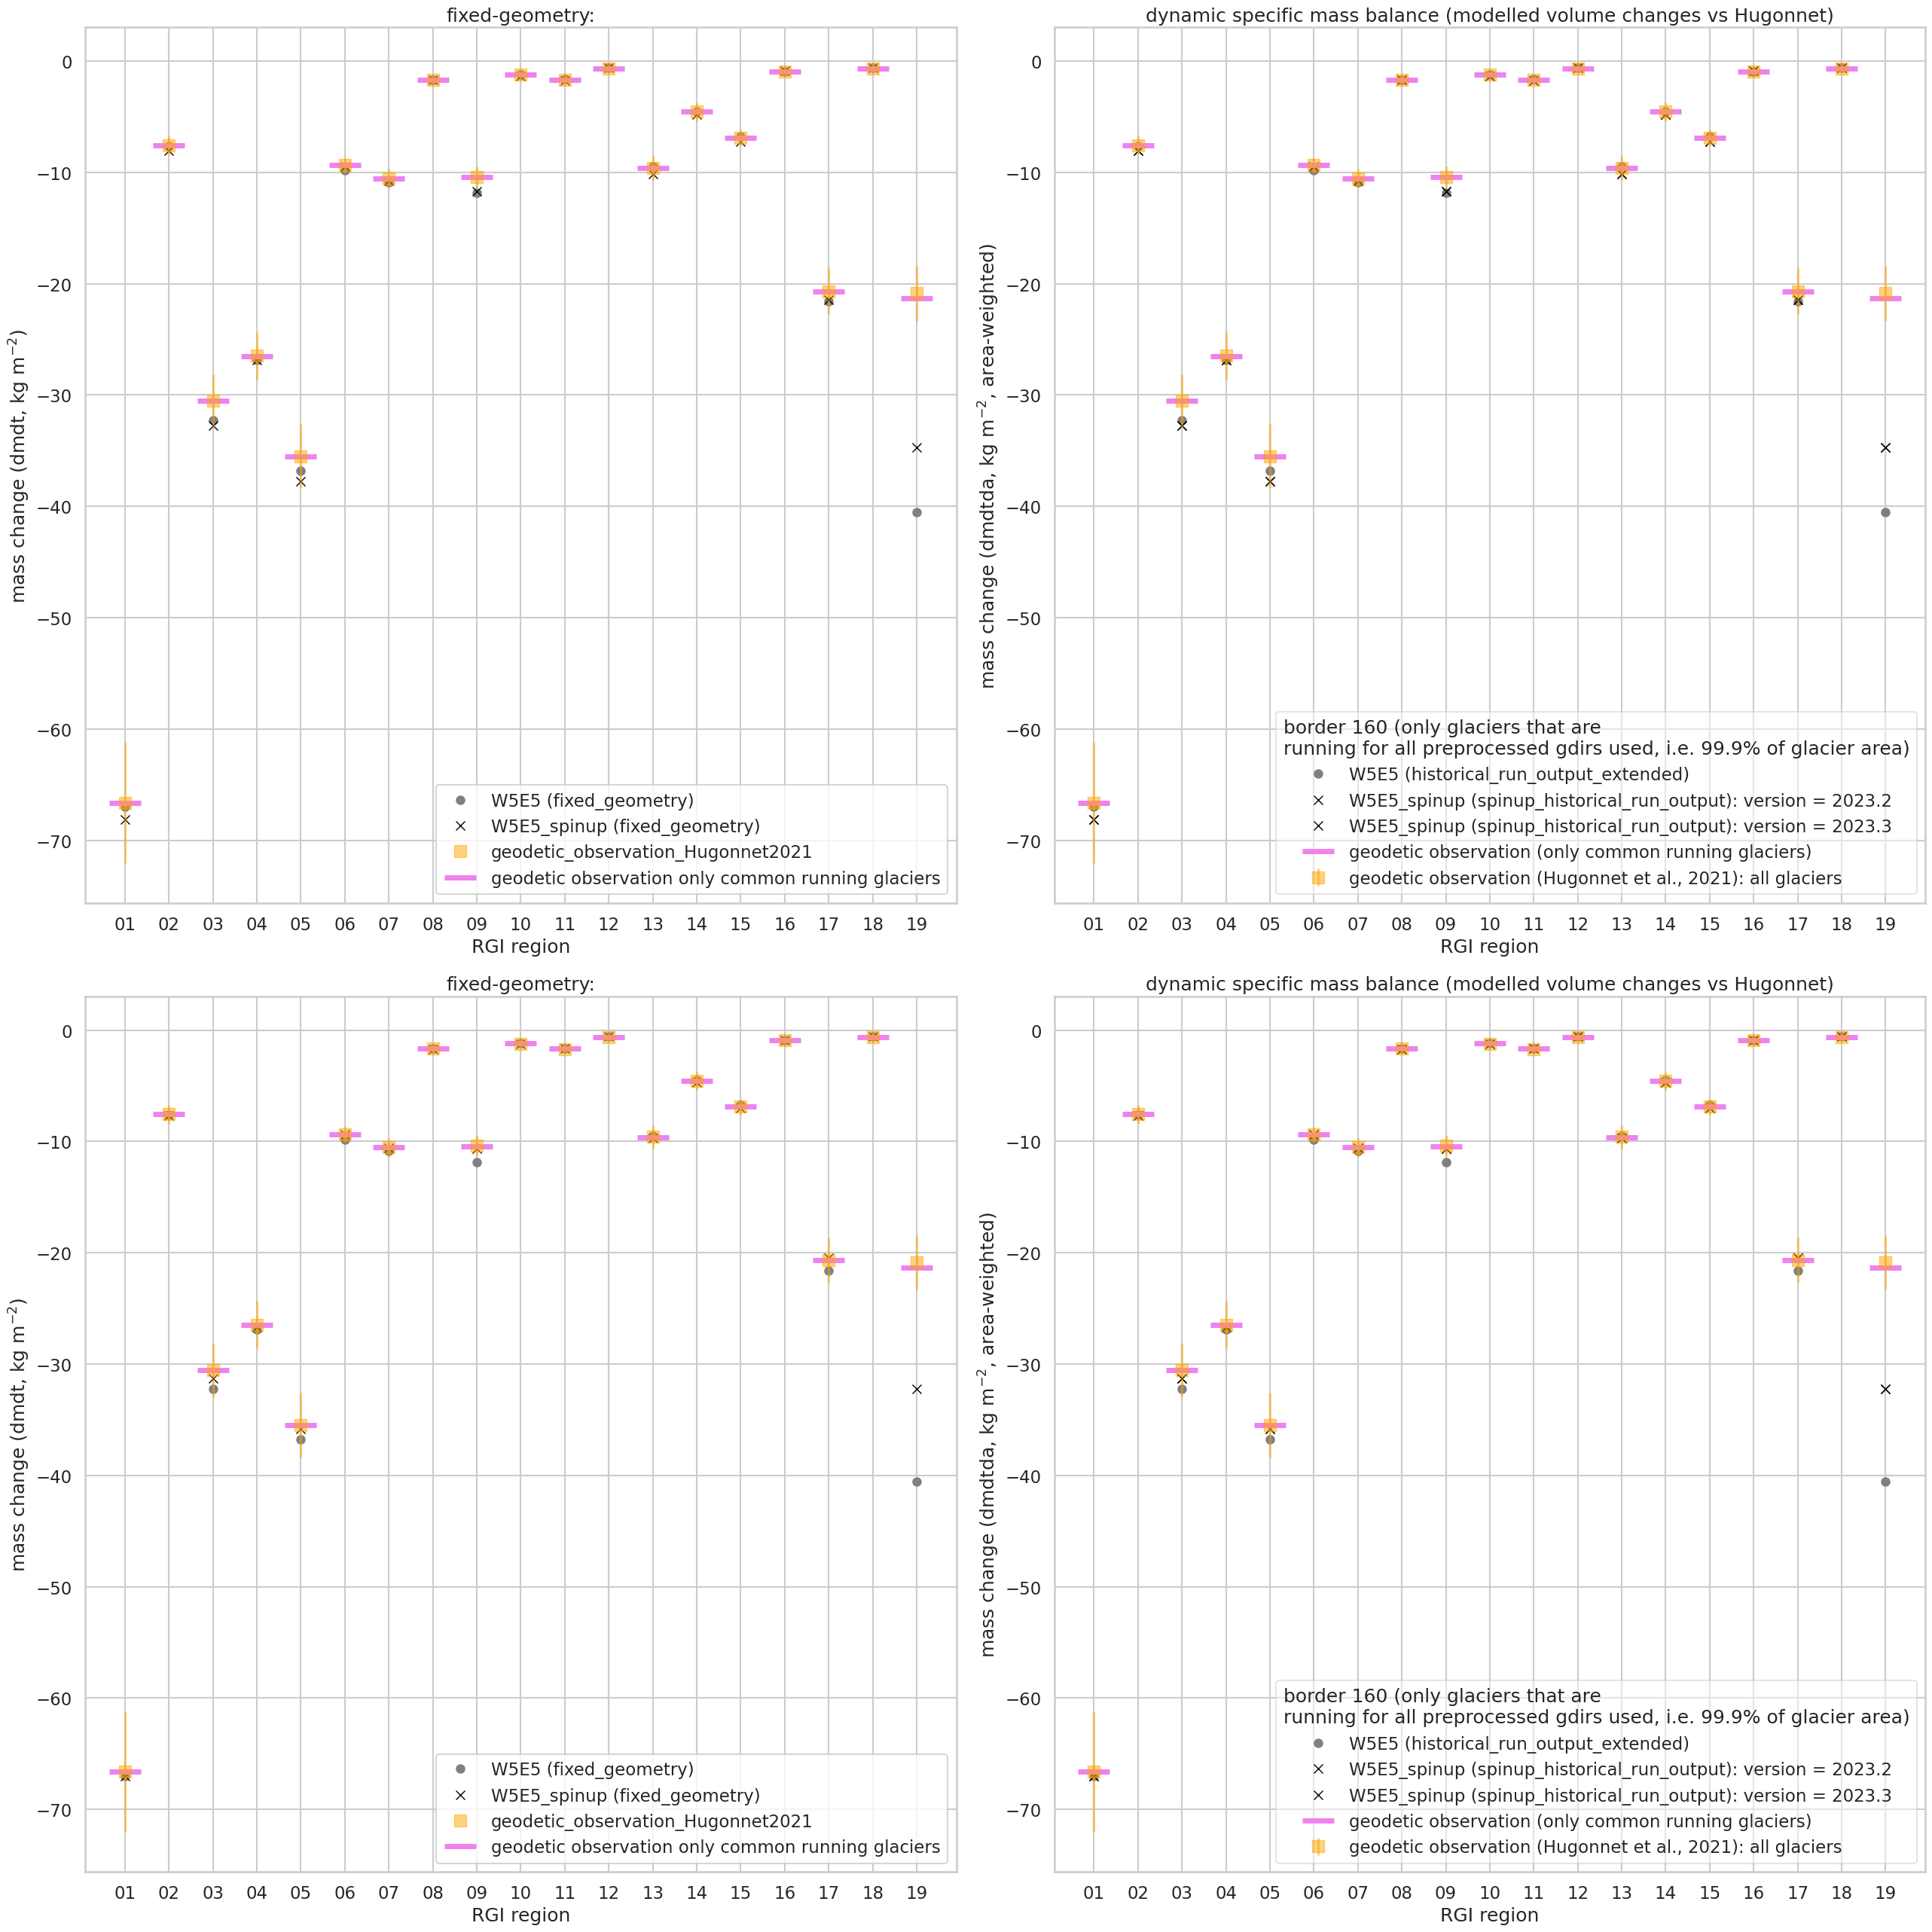

In [59]:

plt.figure(figsize=(26,26))
n=17

ax = plt.subplot2grid((n, n), (0, 0), colspan=8, rowspan=8)

#plt.figure(figsize=(20,10))
#f, ax = plt.subplots()
markers = {'W5E5': 'o', 'W5E5_spinup': 'x'}
for j,version in enumerate(['2023.2', '2023.3']):
    ax = plt.subplot(2,2,j*2+1) #plt.subplot2grid((n, n), (0, 0), colspan=8, rowspan=8)
    dfh = dfh_d[version]

    #plt.figure(figsize=(20,10))
    #f, ax = plt.subplots()
    markers = {'W5E5': 'o', 'W5E5_spinup': 'x'}
    for opt in ['W5E5', 'W5E5_spinup']:
            if opt=='W5E5_spinup':
                #dfh.plot(ax=ax, y=f'dmdtda_OGGM_proj_{opt}', marker='s',
                #                 linestyle='none', markersize=4, color = 'black', alpha = 1, #alphas[exp],
                #                 label=f'W5E5 dynamical run using prepro {opt}')
                dfh.plot(ax=ax, y=f'dmdt_OGGM_{opt}_b_160', marker=markers[opt],
                                 linestyle='none', markersize=8, color = 'black', alpha = 1, #alphas[exp],
                                 label=f'{opt} (fixed_geometry)')

            else:
                dfh.plot(ax=ax, y=f'dmdt_OGGM_{opt}_b_160', marker=markers[opt],
                     linestyle='none', markersize=8, color = 'grey', alpha = 1, #alphas[exp],
                     label=f'{opt} (fixed_geometry)')

    dfh.plot(ax=ax, y='dmdt', yerr='err_dmdt', marker='s', linestyle='none', markersize=12,
                       label = 'geodetic_observation_Hugonnet2021', color = 'orange', alpha = 0.5)
    dfh.plot(ax=ax, y='dmdt_geodetic_only_running_glaciers',  marker="_", linestyle='none', markersize=30,
             label = 'geodetic observation only common running glaciers', color = 'violet',
             alpha = 1, markeredgewidth=5)
    plt.ylabel(r'mass change (dmdt, kg m$^{-2}$)')
    plt.title(r'fixed-geometry:')
    plt.xlabel('RGI region')
    plt.xticks(np.arange(0,19,1), dfh.index.values)
    #f = ax.get_legend()
    #f.remove()
    #plt.ylim([-1400,-50])

for j,version in enumerate(['2023.2', '2023.3']):
    ax = plt.subplot(2,2,j*2+2)
    dfh = dfh_d[version]
    #f, ax = plt.subplots()
    #alphas = {'elev_bands': 1, 'centerlines':0.5}
    markers = {'W5E5': 'o', 'W5E5_spinup': 'x'}
    for opt in ['W5E5', 'W5E5_spinup']:
            if opt=='W5E5_spinup':
                #dfh.plot(ax=ax, y=f'dmdtda_dyna_OGGM_proj_{opt}', marker='s',
                #                 linestyle='none', markersize=4, color = 'black', alpha = 1, #alphas[exp],
                #                 label=f'W5E5 dynamical run using prepro {opt}')
                for j,version in enumerate(['2023.2', '2023.3']):
                    dfh.plot(ax=ax, y=f'dmdt_dyna_OGGM_{opt}_b_160', marker=markers[opt],
                                     linestyle='none', markersize=8, color = 'black', alpha = 1, #alphas[exp],
                                     label=f'{opt} (spinup_historical_run_output): version = {version}')

            else:
                dfh.plot(ax=ax, y=f'dmdt_dyna_OGGM_{opt}_b_160', marker=markers[opt],
                     linestyle='none', markersize=8, color = 'grey', alpha = 1, #alphas[exp],
                     label=f'{opt} (historical_run_output_extended)')

    dfh.plot(ax=ax, y='dmdt', yerr='err_dmdt', marker='s', linestyle='none', markersize=12,
                       label = 'geodetic observation (Hugonnet et al., 2021): all glaciers', color = 'orange', alpha = 0.5)
    dfh.plot(ax=ax, y='dmdt_geodetic_only_running_glaciers', marker="_", linestyle='none', markersize=30,
                       label = 'geodetic observation (only common running glaciers)', color = 'violet', alpha = 1, markeredgewidth=5)
    plt.ylabel(r'mass change (dmdtda, kg m$^{-2}$, area-weighted)')
    plt.xlabel('RGI region')
    plt.title('dynamic specific mass balance (modelled volume changes vs Hugonnet)') # from "spinup/historical_run_output_extended"
    plt.xticks(np.arange(0,19,1), dfh.index.values);
    #plt.ylim([-1400,-50])
    ax.legend(framealpha=0.5, ncol=1, loc='lower right', 
              title=f'border {border} (only glaciers that are\nrunning for all preprocessed gdirs used, i.e. {100*pd_geodetic_running.area.sum()/pd_geodetic.area.sum():0.1f}% of glacier area)')

    plt.tight_layout()


/tmp/ipykernel_2725909/2017426215.py:69: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


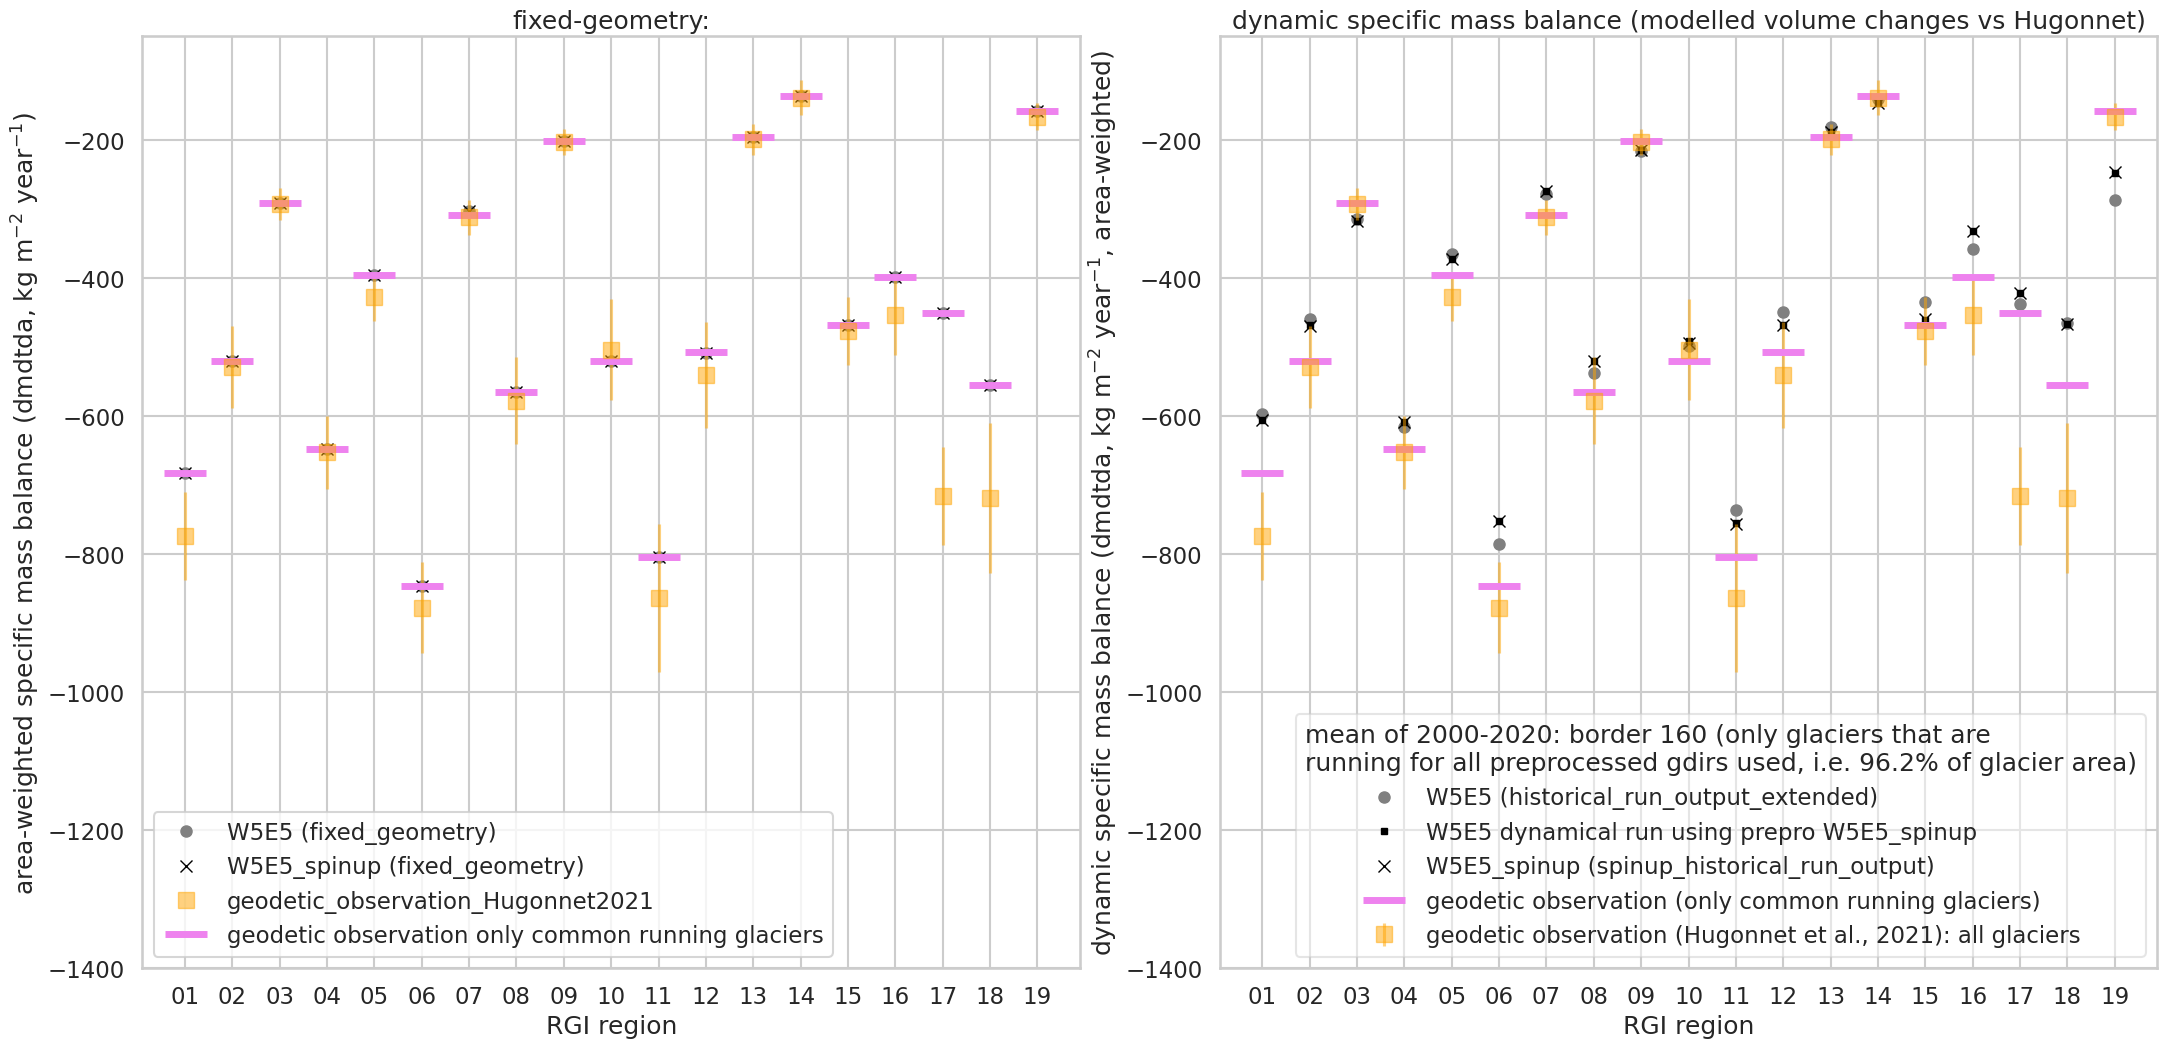

In [70]:
plt.figure(figsize=(26,26))
n=17

ax = plt.subplot2grid((n, n), (0, 0), colspan=8, rowspan=8)

#plt.figure(figsize=(20,10))
#f, ax = plt.subplots()
markers = {'W5E5': 'o', 'W5E5_spinup': 'x'}
for opt in ['W5E5', 'W5E5_spinup']:
        if opt=='W5E5_spinup':
            #dfh.plot(ax=ax, y=f'dmdtda_OGGM_proj_{opt}', marker='s',
            #                 linestyle='none', markersize=4, color = 'black', alpha = 1, #alphas[exp],
            #                 label=f'W5E5 dynamical run using prepro {opt}')
            dfh.plot(ax=ax, y=f'dmdtda_OGGM_{opt}', marker=markers[opt],
                             linestyle='none', markersize=8, color = 'black', alpha = 1, #alphas[exp],
                             label=f'{opt} (fixed_geometry)')

        else:
            dfh.plot(ax=ax, y=f'dmdtda_OGGM_{opt}', marker=markers[opt],
                 linestyle='none', markersize=8, color = 'grey', alpha = 1, #alphas[exp],
                 label=f'{opt} (fixed_geometry)')
            
dfh.plot(ax=ax, y='dmdtda', yerr='err_dmdtda', marker='s', linestyle='none', markersize=12,
                   label = 'geodetic_observation_Hugonnet2021', color = 'orange', alpha = 0.5)
dfh.plot(ax=ax, y='dmdtda_geodetic_only_running_glaciers',  marker="_", linestyle='none', markersize=30,
                   label = 'geodetic observation only common running glaciers', color = 'violet', alpha = 1, markeredgewidth=5)
plt.ylabel(r'area-weighted specific mass balance (dmdtda, kg m$^{-2}$ year$^{-1}$)')
plt.title(r'fixed-geometry:')
plt.xlabel('RGI region')
plt.xticks(np.arange(0,19,1), dfh.index.values)
#f = ax.get_legend()
#f.remove()
plt.ylim([-1400,-50])




ax = plt.subplot2grid((n, n), (0, 9), colspan=8, rowspan=8)

#f, ax = plt.subplots()
#alphas = {'elev_bands': 1, 'centerlines':0.5}
markers = {'W5E5': 'o', 'W5E5_spinup': 'x'}
for opt in ['W5E5', 'W5E5_spinup']:
        if opt=='W5E5_spinup':
            dfh.plot(ax=ax, y=f'dmdtda_dyna_OGGM_proj_{opt}', marker='s',
                             linestyle='none', markersize=4, color = 'black', alpha = 1, #alphas[exp],
                             label=f'W5E5 dynamical run using prepro {opt}')
            dfh.plot(ax=ax, y=f'dmdtda_dyna_OGGM_{opt}', marker=markers[opt],
                             linestyle='none', markersize=8, color = 'black', alpha = 1, #alphas[exp],
                             label=f'{opt} (spinup_historical_run_output)')

        else:
            dfh.plot(ax=ax, y=f'dmdtda_dyna_OGGM_{opt}', marker=markers[opt],
                 linestyle='none', markersize=8, color = 'grey', alpha = 1, #alphas[exp],
                 label=f'{opt} (historical_run_output_extended)')

dfh.plot(ax=ax, y='dmdtda', yerr='err_dmdtda', marker='s', linestyle='none', markersize=12,
                   label = 'geodetic observation (Hugonnet et al., 2021): all glaciers', color = 'orange', alpha = 0.5)
dfh.plot(ax=ax, y='dmdtda_geodetic_only_running_glaciers', marker="_", linestyle='none', markersize=30,
                   label = 'geodetic observation (only common running glaciers)', color = 'violet', alpha = 1, markeredgewidth=5)
plt.ylabel(r'dynamic specific mass balance (dmdtda, kg m$^{-2}$ year$^{-1}$, area-weighted)')
plt.xlabel('RGI region')
plt.title('dynamic specific mass balance (modelled volume changes vs Hugonnet)') # from "spinup/historical_run_output_extended"
plt.xticks(np.arange(0,19,1), dfh.index.values);
plt.ylim([-1400,-50])
ax.legend(framealpha=0.5, ncol=1, loc='lower right', 
          title=f'mean of 2000-2020: border {border} (only glaciers that are\nrunning for all preprocessed gdirs used, i.e. {100*pd_geodetic_running.area.sum()/pd_geodetic.area.sum():0.1f}% of glacier area)')

plt.tight_layout()


In [71]:
ds

<xarray.Dataset>
Dimensions:         (time: 42)
Coordinates:
  * time            (time) float64 1.979e+03 1.98e+03 ... 2.019e+03 2.02e+03
    hydro_year      (time) int64 ...
    hydro_month     (time) int64 ...
    calendar_year   (time) int64 ...
    calendar_month  (time) int64 ...
Data variables:
    volume          (time) float32 4.567e+13 4.567e+13 ... 4.459e+13 4.457e+13
    area            (time) float32 1.327e+11 1.337e+11 ... 1.344e+11 1.344e+11

In [ ]:
border = 160
qc = 'qc3'

plt.figure(figsize=(26,26))
n=17
dfh = pd.read_csv('dmdtda_dmdt_for_prepro_level_5_gdirs_new.csv', index_col=[0])
dfh.index = ['{:02d}'.format(int(rgi_reg)) for rgi_reg in dfh.index]
dfh['dmdt_geodetic_only_running_glaciers'] = pd_working_glaciers_geod.T['dmdt_geodetic_only_running_glaciers'].values
dfh['dmdtda_geodetic_only_running_glaciers'] = pd_working_glaciers_geod.T['dmdtda_geodetic_only_running_glaciers'].values
###
###
ax = plt.subplot2grid((n, n), (0, 0), colspan=8, rowspan=8)

#plt.figure(figsize=(20,10))
ax = plt.gca()
#f, ax = plt.subplots()
alphas = {'elev_bands': 1, 'centerlines':0.5}
markers = {'ERA5': 'o', 'CRU': 'x'}
for exp in ['centerlines', 'elev_bands']:
    for match in ['no_match', 'match_geod']: #, 'match_geod_pergla', 'match_geod_pergla_massredis']:  # 
        for pcp, clim in zip(pcps, clims):
            try:
                dict_key_short = f'{exp}_{pcp}_{clim}_{match}_{qc}_b{border}' #_rgi_{rgi_reg}'
                dfh.plot(ax=ax, y=f'dmdt_OGGM_{dict_key_short}', marker=markers[clim],
                         linestyle='none', markersize=8, color = colors[match], alpha = alphas[exp],
                         label=f'{exp}_{clim}_{pcp}_{match}')
            except:
                pass
dfh.plot(ax=ax, y='dmdt', yerr='err_dmdt', marker='s', linestyle='none', markersize=12,
                   label = 'geodetic_observation_Hugonnet2021', color = 'orange', alpha = 0.5)
dfh.plot(ax=ax, y='dmdt_geodetic_only_running_glaciers',  marker="_", linestyle='none', markersize=30,
                   label = 'geodetic observation only common running glaciers', color = 'violet', alpha = 1, markeredgewidth=5)
plt.ylabel(r'regional total mass change (dmdt, Gt year$^{-1}$)')
plt.xlabel('RGI region')
plt.xticks(np.arange(0,18,1), dfh.index.values)
f = ax.get_legend()
f.remove()
###
ax = plt.subplot2grid((n, n), (9, 0), colspan=8, rowspan=8)
#f, ax = plt.subplots()
alphas = {'elev_bands': 1, 'centerlines':0.5}
markers = {'ERA5': 'o', 'CRU': 'x'}
dfh.plot(ax=ax, y='dmdtda', yerr='err_dmdtda', marker='s', linestyle='none', markersize=12, linewidth=4,
                   label = 'geodetic observation (Hugonnet et al., 2021)', color = 'orange', alpha = 0.7)
for exp in ['centerlines', 'elev_bands']:
    for match in ['no_match', 'match_geod']: #, 'match_geod_pergla', 'match_geod_pergla_massredis']:  # 
        for pcp, clim in zip(pcps, clims):
            try:
                dict_key_short = f'{exp}_{pcp}_{clim}_{match}_{qc}_b{border}' #_rgi_{rgi_reg}'
                dfh.plot(ax=ax, y=f'dmdtda_OGGM_{dict_key_short}', marker=markers[clim],
                         linestyle='none', markersize=8, color = colors[match], alpha = alphas[exp],
                         label=f'{exp}_{clim}_{pcp}_{match}')
            except:
                pass
#t=ax.get_legend_handles_labels()
#t[0] = [t[0][-1]].append(t[:-1])

dfh.plot(ax=ax, y='dmdtda_geodetic_only_running_glaciers',  marker="_", linestyle='none', markersize=30,
                   label = 'geodetic observation only common running glaciers', color = 'violet', alpha = 1, markeredgewidth=5)
plt.ylabel(r'area-weighted specific mass balance (dmdtda, kg m$^{-2}$ year$^{-1}$)')
plt.xlabel('RGI region')
plt.xticks(np.arange(0, 18, 1), dfh.index.values)
f = ax.get_legend()
f.remove()
plt.title('area-weighted mean MB from "fixed_geometry_mass_balance"')


##
#plt.figure(figsize=(20,10))
ax = plt.subplot2grid((n, n), (9, 9), colspan=8, rowspan=8)

#f, ax = plt.subplots()
alphas = {'elev_bands': 1, 'centerlines':0.5}
markers = {'ERA5': 'o', 'CRU': 'x'}
bu=[]
for exp in ['centerlines', 'elev_bands']:
    for match in ['no_match', 'match_geod']: #, 'match_geod_pergla', 'match_geod_pergla_massredis']:  # 
        for pcp, clim in zip(pcps, clims):
            try:
                dict_key_short = f'{exp}_{pcp}_{clim}_{match}_{qc}_b{border}' #_rgi_{rgi_reg}'
                dfh.plot(ax=ax, y=f'dmdtda_dyna_OGGM_{dict_key_short}', marker=markers[clim],
                         linestyle='none', markersize=8, color = colors[match], alpha = alphas[exp],
                         label=f'{exp}_{clim}_{pcp}_{match}')
            except:
                pass
dfh.plot(ax=ax, y='dmdtda', yerr='err_dmdtda', marker='s', linestyle='none', markersize=12,
                   label = 'geodetic observation (Hugonnet et al., 2021)', color = 'orange', alpha = 0.7)
dfh.plot(ax=ax, y='dmdtda_geodetic_only_running_glaciers',  marker="_", linestyle='none', markersize=30,
                   label = 'geodetic observation (only common running glaciers)', color = 'violet', alpha = 1, markeredgewidth=5)
plt.ylabel(r'dynamic specific mass balance (dmdtda, kg m$^{-2}$ year$^{-1}$)')
plt.xlabel('RGI region')
plt.title('using volume changes from "historical_run_output_extended"')
plt.xticks(np.arange(0,18,1), dfh.index.values);
plt.ylim([-1600,-50])
ax.legend(framealpha=0.5, ncol=1, loc=3, bbox_to_anchor=(0.17,1.3),
          title=f'mean of 2000-2020: {qc}, border {border} (only glaciers that are\nrunning for all preprocessed gdirs used, i.e. {len(all_running_rgis)*100/len(pd_working):0.1f}%)')

#ax.legend()
######
#plt.tight_layout()

ax = plt.subplot2grid((n, n), (1, 9), rowspan=6, colspan=1)
rgi_index = ['{:02d}'.format(int(rgi_reg)) for rgi_reg in np.arange(1,20)]
dfh.loc['all', 'dmdt'] = dfh.loc[rgi_index].dmdt.sum()
dfh.loc['all', 'err_dmdt'] = dfh.loc[rgi_index].err_dmdt.sum()

dfh.loc['all', 'period'] = dfh.period[0]
for exp in ['elev_bands', 'centerlines']:
        for match in ['no_match', 'match_geod']: #, 'match_geod_pergla', 'match_geod_pergla_massredis']:  
            for pcp, clim in zip(pcps, clims):
                try:
                    dict_key_short = f'{exp}_{pcp}_{clim}_{match}_{qc}_b{border}'
                    dfh.loc['all', f'dmdt_OGGM_{opt}'] = dfh.loc[rgi_index, f'dmdt_OGGM_{opt}'].sum()
                except:
                    pass
###
#plt.figure(figsize=(3,6))
ax = plt.gca()
#ax.errorbar(['geodetic observation (Hugonnet et al., 2021)'],
#            df_dmdt_all.dmdt, yerr=df_dmdt_all.err_dmdt,
#            marker='s', color='orange', alpha=0.8)

df_dmdt_all = dfh.loc['all_without_19'][1:].dropna()
plt.axhline(df_dmdt_all.dmdt, color='orange', alpha = 0.3)
plt.axhspan(df_dmdt_all.dmdt-df_dmdt_all.err_dmdt,
            df_dmdt_all.dmdt + df_dmdt_all.err_dmdt, alpha = 0.1, color='orange')

#dmdtda_working_glaciers_geods['all_without_19'] = np.average(pd_geodetic_running.dmdtda, weights=pd_geodetic_running.area)*1e3
plt.axhline((pd_geodetic_running.dmdtda*1e3*pd_geodetic_running.area).sum()*1e-12,
            color='violet', alpha=0.5, linewidth=5)
for exp in ['centerlines', 'elev_bands']:
    for match in ['no_match', 'match_geod']: #, 'match_geod_pergla', 'match_geod_pergla_massredis']:  # 
        for pcp, clim in zip(pcps, clims):
            try:
                dict_key_short = f'{exp}_{pcp}_{clim}_{match}_{qc}_b{border}' #_rgi_{rgi_reg}'
                ax.errorbar(x=[f'{exp}_{clim}_{pcp}_{match}'], # [0]
                            y=df_dmdt_all[f'dmdt_OGGM_{dict_key_short}'],
                            marker=markers[clim],
                            linestyle='none', markersize=8, color=colors[match], alpha=alphas[exp],
                            label=f'{exp}_{clim}_{pcp}_{match}')
            except:
                pass
plt.ylabel(r'world-wide total mass-change (dmdt, Gt year$^{-1}$)')
plt.xticks(ticks=[3.5],labels=['all without RGI 19'])
plt.xlim([-1,9.5])
plt.grid(axis='x')

plt.savefig(f'dmdtda_dmdt_for_prepro_level_gdirs_{qc}_b{border}.png', bbox_inches='tight', pad_inches=0)
plt.savefig(f'dmdtda_dmdt_for_prepro_level_gdirs_{qc}_b{border}.pdf', bbox_inches='tight', pad_inches=0.2)

In [84]:
dfh

period   dmdt  err_dmdt  dmdtda  err_dmdtda  \
01  2000-01-01_2020-01-01 -66.61      5.43 -773.79       63.56   
02  2000-01-01_2020-01-01  -7.56      0.85 -529.43       59.52   
03  2000-01-01_2020-01-01 -30.54      2.42 -292.74       23.41   
04  2000-01-01_2020-01-01 -26.48      2.13 -652.65       52.90   
05  2000-01-01_2020-01-01 -35.49      2.89 -427.09       35.03   
06  2000-01-01_2020-01-01  -9.36      0.70 -877.49       66.59   
07  2000-01-01_2020-01-01 -10.53      0.85 -312.12       25.27   
08  2000-01-01_2020-01-01  -1.67      0.18 -577.56       62.94   
09  2000-01-01_2020-01-01 -10.40      0.94 -202.92       18.47   
10  2000-01-01_2020-01-01  -1.22      0.18 -503.76       73.45   
11  2000-01-01_2020-01-01  -1.69      0.21 -863.75      107.67   
12  2000-01-01_2020-01-01  -0.67      0.09 -540.81       76.48   
13  2000-01-01_2020-01-01  -9.60      1.06 -199.00       22.15   
14  2000-01-01_2020-01-01  -4.56      0.84 -138.59       25.49   
15  2000-01-01_2020-01-01  -6.87      0.71 -477.23       49.28   
16  2000-01-01_2020-01-01  -0.93      0.12 -453.83       58.23   
17  2000-01-01_2020-01-01 -20.68      2.05 -715.61       71.35   
18  2000-01-01_2020-01-01  -0.65      0.10 -718.22      108.68   
19  2000-01-01_2020-01-01 -20.87      2.46 -166.49       19.71   

    dmdtda_OGGM_W5E5  dmdtda_dyna_OGGM_W5E5  area_OGGM_2000_W5E5  \
01       -682.867030            -678.438420         8.671674e+10   
02       -520.062346            -458.972311         1.504937e+10   
03       -290.846673            -313.764167         1.051061e+11   
04       -648.224633            -616.008782         4.091842e+10   
05       -395.943637            -365.575862         8.972035e+10   
06       -846.380030            -785.780554         1.105953e+10   
07       -303.312236            -277.919769         3.397128e+10   
08       -565.171709            -537.845993         2.948529e+09   
09       -202.111130            -216.460018         5.157186e+10   
10       -520.976144            -497.623844         2.323438e+09   
11       -804.911322            -735.500422         2.091911e+09   
12       -508.004299            -448.327761         1.151103e+09   
13       -195.669760            -181.435905         4.924147e+10   
14       -135.945961            -141.183575         3.360750e+10   
15       -468.178425            -434.848781         1.472894e+10   
16       -399.241599            -357.715037         2.341109e+09   
17       -450.563247            -682.994657         2.940483e+10   
18       -554.401058            -464.557271         1.173934e+09   
19       -157.501651            -289.806633         1.358448e+11   

    vol_OGGM_2000_W5E5  dmdtda_OGGM_W5E5_spinup  dmdtda_dyna_OGGM_W5E5_spinup  \
01        1.946116e+13              -682.867030                   -678.438420   
02        1.079486e+12              -520.062346                   -458.972311   
03        2.832337e+13              -290.846673                   -313.764167   
04        8.672361e+12              -648.224633                   -616.008782   
05        1.577052e+13              -395.943637                   -365.575862   
06        3.785239e+12              -846.380030                   -785.780554   
07        7.565840e+12              -303.312236                   -277.919769   
08        3.061212e+11              -565.171709                   -537.845993   
09        1.468843e+13              -202.111130                   -216.460018   
10        1.407830e+11              -520.976144                   -497.623844   
11        1.328835e+11              -804.911322                   -735.500422   
12        6.017304e+10              -508.004299                   -448.327761   
13        3.311656e+12              -195.669760                   -181.435905   
14        2.893592e+12              -135.945961                   -141.183575   
15        9.026204e+11              -468.178425                   -434.848781   
16        9.756864e+10              -399.

In [74]:
    dfhh = pd.concat([dfh,pd_working_glaciers_geod.T], axis=1)
    dfhh.to_csv(f'oggm_v161_w5e5_spinup_dmdtda_area_vol_for_prepro_level_5_gdirs.csv')

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [72]:
dfhh

period   dmdt  err_dmdt  dmdtda  err_dmdtda  \
01  2000-01-01_2020-01-01 -66.61      5.43 -773.79       63.56   
02  2000-01-01_2020-01-01  -7.56      0.85 -529.43       59.52   
03  2000-01-01_2020-01-01 -30.54      2.42 -292.74       23.41   
04  2000-01-01_2020-01-01 -26.48      2.13 -652.65       52.90   
05  2000-01-01_2020-01-01 -35.49      2.89 -427.09       35.03   
06  2000-01-01_2020-01-01  -9.36      0.70 -877.49       66.59   
07  2000-01-01_2020-01-01 -10.53      0.85 -312.12       25.27   
08  2000-01-01_2020-01-01  -1.67      0.18 -577.56       62.94   
09  2000-01-01_2020-01-01 -10.40      0.94 -202.92       18.47   
10  2000-01-01_2020-01-01  -1.22      0.18 -503.76       73.45   
11  2000-01-01_2020-01-01  -1.69      0.21 -863.75      107.67   
12  2000-01-01_2020-01-01  -0.67      0.09 -540.81       76.48   
13  2000-01-01_2020-01-01  -9.60      1.06 -199.00       22.15   
14  2000-01-01_2020-01-01  -4.56      0.84 -138.59       25.49   
15  2000-01-01_2020-01-01  -6.87      0.71 -477.23       49.28   
16  2000-01-01_2020-01-01  -0.93      0.12 -453.83       58.23   
17  2000-01-01_2020-01-01 -20.68      2.05 -715.61       71.35   
18  2000-01-01_2020-01-01  -0.65      0.10 -718.22      108.68   
19  2000-01-01_2020-01-01 -20.87      2.46 -166.49       19.71   

    dmdtda_OGGM_W5E5  dmdtda_dyna_OGGM_W5E5  area_OGGM_2000_W5E5  \
01       -682.867030            -678.438420         8.671674e+10   
02       -520.062346            -458.972311         1.504937e+10   
03       -290.846673            -313.764167         1.051061e+11   
04       -648.224633            -616.008782         4.091842e+10   
05       -395.943637            -365.575862         8.972035e+10   
06       -846.380030            -785.780554         1.105953e+10   
07       -303.312236            -277.919769         3.397128e+10   
08       -565.171709            -537.845993         2.948529e+09   
09       -202.111130            -216.460018         5.157186e+10   
10       -520.976144            -497.623844         2.323438e+09   
11       -804.911322            -735.500422         2.091911e+09   
12       -508.004299            -448.327761         1.151103e+09   
13       -195.669760            -181.435905         4.924147e+10   
14       -135.945961            -141.183575         3.360750e+10   
15       -468.178425            -434.848781         1.472894e+10   
16       -399.241599            -357.715037         2.341109e+09   
17       -450.563247            -682.994657         2.940483e+10   
18       -554.401058            -464.557271         1.173934e+09   
19       -157.501651            -289.806633         1.358448e+11   

    vol_OGGM_2000_W5E5  dmdtda_OGGM_W5E5_spinup  dmdtda_dyna_OGGM_W5E5_spinup  \
01        1.946116e+13              -682.867030                   -678.438420   
02        1.079486e+12              -520.062346                   -458.972311   
03        2.832337e+13              -290.846673                   -313.764167   
04        8.672361e+12              -648.224633                   -616.008782   
05        1.577052e+13              -395.943637                   -365.575862   
06        3.785239e+12              -846.380030                   -785.780554   
07        7.565840e+12              -303.312236                   -277.919769   
08        3.061212e+11              -565.171709                   -537.845993   
09        1.468843e+13              -202.111130                   -216.460018   
10        1.407830e+11              -520.976144                   -497.623844   
11        1.328835e+11              -804.911322                   -735.500422   
12        6.017304e+10              -508.004299                   -448.327761   
13        3.311656e+12              -195.669760                   -181.435905   
14        2.893592e+12              -135.945961                   -141.183575   
15        9.026204e+11              -468.178425                   -434.848781   
16        9.756864e+10              -399.

In [62]:
dfhh

Empty DataFrame
Columns: []
Index: [01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [28]:
xr.open_dataset(fd + f'historical_run_output_extended_{rgi_reg}.nc').volume

<xarray.DataArray 'volume' (time: 119, rgi_id: 2752)>
[327488 values with dtype=float32]
Coordinates:
  * time            (time) float64 1.902e+03 1.903e+03 ... 2.019e+03 2.02e+03
  * rgi_id          (rgi_id) object 'RGI60-19.00001' ... 'RGI60-19.02752'
    hydro_year      (time) int64 ...
    hydro_month     (time) int64 ...
    calendar_year   (time) int64 ...
    calendar_month  (time) int64 ...
Attributes:
    description:  Total glacier volume (extended with MB data)
    unit:         m 3

In [31]:
fd_w5e5_spinup = '/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2023.2/elev_bands/W5E5_spinup/RGI62/b_160/L5/summary/'
fd = '/home/www/oggm/gdirs/oggm_v1.6/L3-L5_files/2023.2/elev_bands/W5E5/RGI62/b_160/L5/summary/'

np.testing.assert_allclose(xr.open_dataset(fd_w5e5_spinup + f'historical_run_output_extended_{rgi_reg}.nc').volume,
                           xr.open_dataset(fd + f'historical_run_output_extended_{rgi_reg}.nc').volume)

In [24]:
dfh

period   dmdt  err_dmdt  dmdtda  err_dmdtda  \
01  2000-01-01_2020-01-01 -66.61      5.43 -773.79       63.56   
02  2000-01-01_2020-01-01  -7.56      0.85 -529.43       59.52   
03  2000-01-01_2020-01-01 -30.54      2.42 -292.74       23.41   
04  2000-01-01_2020-01-01 -26.48      2.13 -652.65       52.90   
05  2000-01-01_2020-01-01 -35.49      2.89 -427.09       35.03   
06  2000-01-01_2020-01-01  -9.36      0.70 -877.49       66.59   
07  2000-01-01_2020-01-01 -10.53      0.85 -312.12       25.27   
08  2000-01-01_2020-01-01  -1.67      0.18 -577.56       62.94   
09  2000-01-01_2020-01-01 -10.40      0.94 -202.92       18.47   
10  2000-01-01_2020-01-01  -1.22      0.18 -503.76       73.45   
11  2000-01-01_2020-01-01  -1.69      0.21 -863.75      107.67   
12  2000-01-01_2020-01-01  -0.67      0.09 -540.81       76.48   
13  2000-01-01_2020-01-01  -9.60      1.06 -199.00       22.15   
14  2000-01-01_2020-01-01  -4.56      0.84 -138.59       25.49   
15  2000-01-01_2020-01-01  -6.87      0.71 -477.23       49.28   
16  2000-01-01_2020-01-01  -0.93      0.12 -453.83       58.23   
17  2000-01-01_2020-01-01 -20.68      2.05 -715.61       71.35   
18  2000-01-01_2020-01-01  -0.65      0.10 -718.22      108.68   
19  2000-01-01_2020-01-01 -20.87      2.46 -166.49       19.71   

    dmdtda_dyna_OGGM_W5E5  area_OGGM_2000_W5E5  vol_OGGM_2000_W5E5  \
01            -678.438420         8.671674e+10        1.946116e+13   
02            -458.972311         1.504937e+10        1.079486e+12   
03            -313.764167         1.051061e+11        2.832337e+13   
04            -616.008782         4.091842e+10        8.672361e+12   
05            -365.575862         8.972035e+10        1.577052e+13   
06            -785.780554         1.105953e+10        3.785239e+12   
07            -277.919769         3.397128e+10        7.565840e+12   
08            -537.845993         2.948529e+09        3.061212e+11   
09            -216.460018         5.157186e+10        1.468843e+13   
10            -497.623844         2.323438e+09        1.407830e+11   
11            -735.500422         2.091911e+09        1.328835e+11   
12            -448.327761         1.151103e+09        6.017304e+10   
13            -181.435905         4.924147e+10        3.311656e+12   
14            -141.183575         3.360750e+10        2.893592e+12   
15            -434.848781         1.472894e+10        9.026204e+11   
16            -357.715037         2.341109e+09        9.756864e+10   
17            -682.994657         2.940483e+10        5.339397e+12   
18            -464.557271         1.173934e+09        6.891259e+10   
19            -289.806633         1.358448e+11        4.596159e+13   

    dmdtda_dyna_OGGM_W5E5_spinup  area_OGGM_2000_W5E5_spinup  \
01                   -678.438420                8.671674e+10   
02                   -458.972311                1.504937e+10   
03                   -313.764167                1.051061e+11   
04                   -616.008782                4.091842e+10   
05                   -365.575862                8.972035e+10   
06                   -785.780554                1.105953e+10   
07                   -277.919769                3.397128e+10   
08                   -537.845993                2.948529e+09   
09                   -216.460018                5.157186e+10   
10                   -497.623844                2.323438e+09   
11                   -735.500422                2.091911e+09   
12                   -448.327761                1.151103e+09   
13                   -181.435905                4.924147e+10   
14                   -141.183575                3.360750e+10   
15                   -434.848781                1.472894e+10   
16                   -357.715037                2.341109e+09   
17                   -682.994657                2.940483e+10   
18                   -464.557271                1.173934e+09   
19                   -289.806633                1.358448e+11   

    vol_OGGM_200